In [1]:
import typing as t
import random

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (5, 3)

При помощи возможностей по автоматическому дифференцированию, которые предоставляет библиотека PyTorch, найдите минимум функции $ y=ln(x^2+10x+10) $ на отрезке \[-10, 10]. Реализуйте процесс поиска экстремума таким образом, чтобы при нахождении точки экстремума процедура поиска останавливалась. Продемонстрируйте процесс оптимизации. Изобразите график функции y(x) на заданном отрезке.

In [4]:
def save_animation(xs: list[torch.Tensor], path: str, limit: int = 500, delay: int = 50) -> None:
    xs_ = xs.copy()
    delayed = xs_[-1]
    if len(xs_) > limit:
        xs_ = xs_[::len(xs_) // limit]
    for i in range(delay):
        xs_.append(delayed)

    with tqdm(total=len(xs_) + 1) as pbar:
        def animate(i):
            scatter.set_data(xs_[i].detach(), f(xs_[i]).detach())
            pbar.update()

        fig, ax = plt.subplots(1, 1)
        ax.plot(X.detach(), Y.detach())
        scatter, = ax.plot([], [], marker="o", color="r")
        anim = animation.FuncAnimation(fig, animate, interval=1, frames=len(xs_))
        anim.save(path, writer="pillow", fps=20)
        plt.close()


def answer(x: torch.Tensor, sign: t.Literal[-1, 1]) -> None:
    x, y = x.detach().item(), f(x).detach().item()
    print(f"Найден локальный {'минимум' if sign == -1 else 'максимум'}: {x=:5f}, {y=:5f}")

    plt.plot(X.detach(), f(X).detach())
    plt.scatter(x, y, color="r")

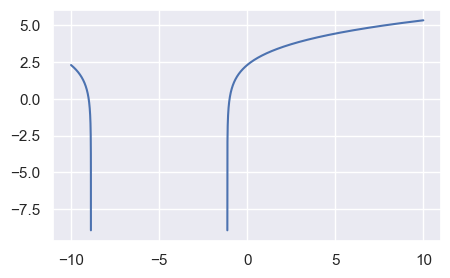

In [5]:
def f(x: torch.Tensor) -> torch.Tensor:
    return torch.log(x ** 2 + 10 * x + 10)


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.001

X = torch.arange(START, END + EPS, EPS, requires_grad=True)
Y = f(X)
plt.plot(X.detach(), Y.detach());

### Аналитически

Идейный пример. Не думаю, что от нас хотят этого.

In [6]:
x_extrema = None
for i, x in tqdm(enumerate(X), total=X.size(0)):
    y = f(x)
    if torch.isnan(y):
        continue

    y.backward()
    if SIGN * X.grad[i] < 0:  # очень наивное предположение
        x_extrema = x
        break

 44%|████▍     | 8873/20001 [01:09<01:26, 128.20it/s]  


Найден локальный минимум: x=-1.127000, y=-8.950289


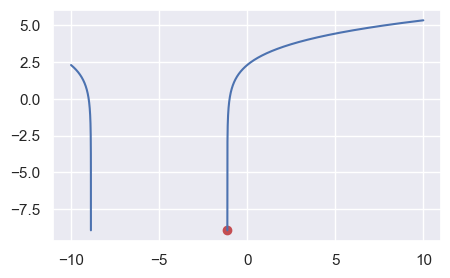

In [7]:
answer(x_extrema, SIGN)

### Метод оптимизации

In [8]:
def optimize(
        start: float,
        end: float,
        eps: float,
        sign: t.Literal[-1, 1],
        func: t.Callable,
        alpha: float,
        initial_state: float = None,
) -> tuple[torch.Tensor, list[torch.Tensor]]:
    def sign_f(x: torch.Tensor) -> torch.Tensor:
        return -sign * func(x)

    initial_state = random.uniform(start, end) if initial_state is None else initial_state
    x = torch.tensor(initial_state, dtype=torch.float, requires_grad=True)

    interval_eps = end - start
    xs = [x.detach().clone()]
    while True:
        if x < start - interval_eps or x > end + interval_eps:  # выход за границу больше чем на (END - START)
            break

        y = sign_f(x)

        if torch.isnan(y):  # функция не определена
            if len(xs) < 2:
                x = torch.tensor(torch.nan)
                xs.append(x)
                break
            xs.pop()
            x = xs[-1]
            break

        y.backward()

        grad = x.grad.detach().clone()
        x.grad.zero_()

        with torch.no_grad():
            x -= alpha * grad
            if torch.abs(x - xs[-1]) < eps:
                xs.append(x.detach().clone())
                break

        xs.append(x.detach().clone())

    # давали шанс шарику одуматься и закатиться в нужный интервал
    # если этого не произошло - искомый экстремум - одна из границ
    if x < start or x > end:
        start_t, end_t = torch.tensor(start), torch.tensor(end)
        start_yx, end_yx = (sign_f(start_t), start_t), (sign_f(end_t), end_t)
        _, x = min(start_yx, end_yx)
        xs.append(x.detach().clone())

    return x, xs

#### Билет №1

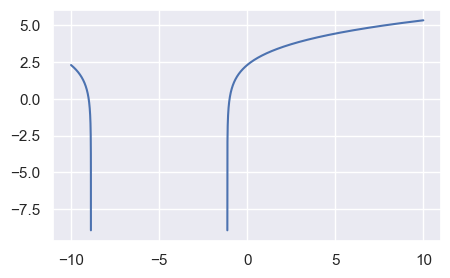

In [9]:
def f(x: torch.Tensor) -> torch.Tensor:
    return torch.log(x ** 2 + 10 * x + 10)


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.0000001
ALPHA = 0.00001

X = torch.arange(START, END + 0.001, 0.001, requires_grad=True)
Y = f(X)
plt.plot(X.detach(), Y.detach());

Найден локальный минимум: x=-8.875940, y=-3.775802


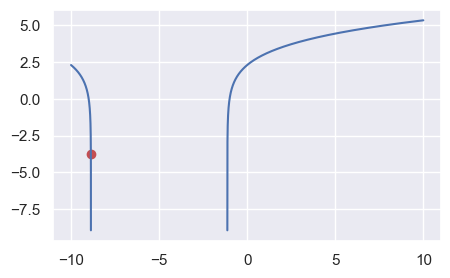

In [10]:
x, xs = optimize(start=START, end=END, eps=EPS, sign=SIGN, func=f, alpha=ALPHA, initial_state=-9.8)
answer(x, SIGN)

In [11]:
save_animation(xs, "autograd/optimization_1_1.gif")

100%|██████████| 552/552 [00:23<00:00, 23.89it/s]


![](autograd/optimization_1_1.gif)

Найден локальный минимум: x=-1.125162, y=-4.242814


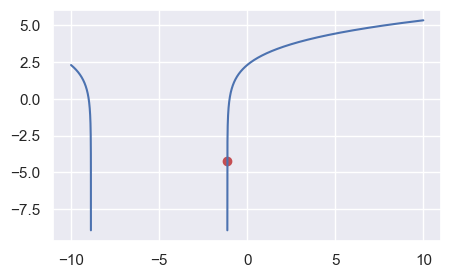

In [12]:
x, xs = optimize(start=START, end=END, eps=EPS, sign=SIGN, func=f, alpha=ALPHA, initial_state=1.8)
answer(x, SIGN)

In [13]:
save_animation(xs, "autograd/optimization_1_2.gif")

100%|██████████| 552/552 [00:22<00:00, 24.65it/s]


![](autograd/optimization_1_2.gif)

#### Билет №2

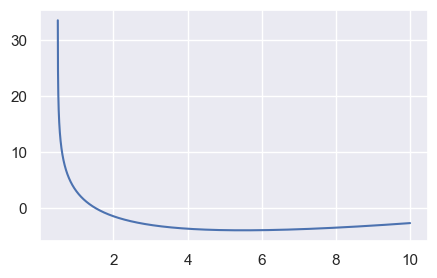

In [14]:
def f(x: torch.Tensor) -> torch.Tensor:
    return x - 5 * torch.log(2 * x - 1) + 2


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.000001
ALPHA = 0.001

X = torch.arange(START, END + 0.001, 0.001, requires_grad=True)
Y = f(X)
plt.plot(X.detach(), Y.detach());

Найден локальный минимум: x=5.494049, y=-4.012922


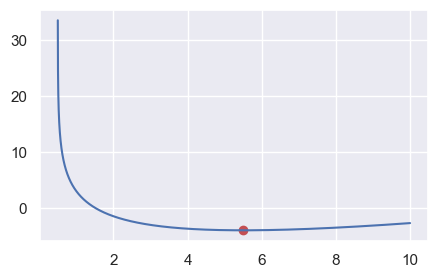

In [15]:
x, xs = optimize(start=START, end=END, eps=EPS, sign=SIGN, func=f, alpha=ALPHA, initial_state=0.6)
answer(x, SIGN)

In [16]:
save_animation(xs, "autograd/optimization_2.gif")

100%|██████████| 554/554 [00:21<00:00, 25.82it/s]


![](autograd/optimization_2.gif)

#### Билет №3

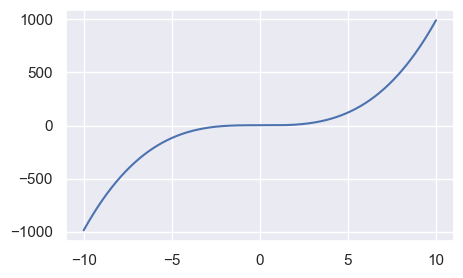

In [17]:
def f(x: torch.Tensor) -> torch.Tensor:
    return x ** 3 - x + 2


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.000001
ALPHA = 0.001

X = torch.arange(START, END + 0.001, 0.001, requires_grad=True)
Y = f(X)
plt.plot(X.detach(), Y.detach());

Найден локальный минимум: x=0.577632, y=1.615100


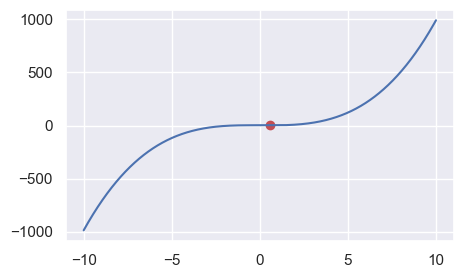

In [18]:
x, xs = optimize(start=START, end=END, eps=EPS, sign=SIGN, func=f, alpha=ALPHA, initial_state=9.1)
answer(x, SIGN)

In [19]:
save_animation(xs, "autograd/optimization_3_1.gif")

100%|██████████| 641/641 [00:27<00:00, 23.15it/s]


![](autograd/optimization_3_1.gif)

Найден локальный минимум: x=-10.000000, y=-988.000000


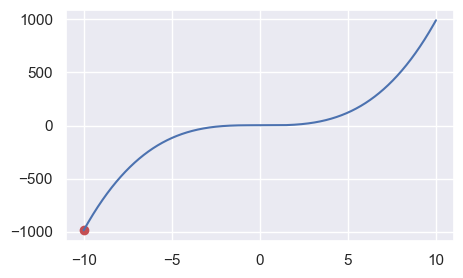

In [20]:
x, xs = optimize(start=START, end=END, eps=EPS, sign=SIGN, func=f, alpha=ALPHA, initial_state=-6)
answer(x, SIGN)

In [21]:
save_animation(xs, "autograd/optimization_3_2.gif")

100%|██████████| 100/100 [00:04<00:00, 21.32it/s]


![](autograd/optimization_3_2.gif)